<a target="_blank" href="https://colab.research.google.com/github/Teghfo/deeplearning-bootcamp-pytorch/blob/master/notebooks/06-ImageSegmentation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [40]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

In [12]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-02-09 08:23:05--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-02-09 08:23:05--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-02-09 08:23:06--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [20]:
import os
from glob import glob

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(glob(input_dir + "/*.jpg"))
target_paths = sorted(glob(target_dir + "/*.png"))

In [21]:
len(input_img_paths)

7390

In [22]:
len(target_paths)

7390

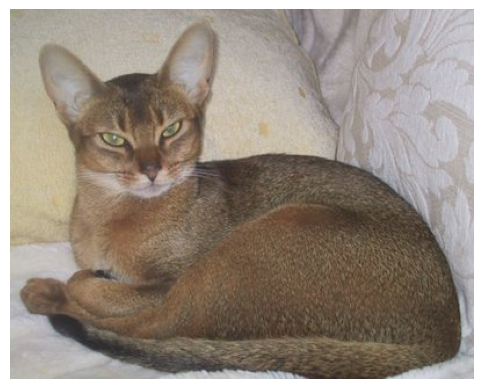

In [36]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(input_img_paths[13])[:, : , ::-1]

plt.axis("off")
plt.imshow(img)

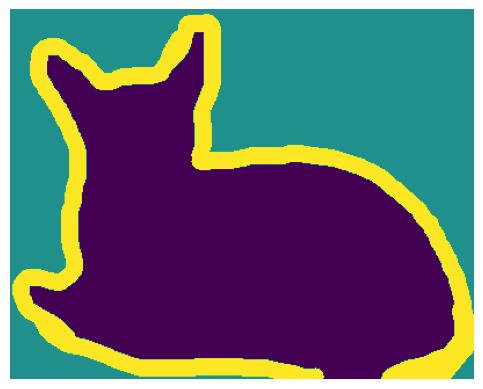

In [37]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = cv2.imread(target_paths[13])
display_target(img)

In [59]:
class SegmentDataset(Dataset):
  def __init__(self, image_dir, target_dir, img_size=(200,200),
               random_state=1337, train=True, transform=None):

    all_images_path = sorted(glob(image_dir + "/*.jpg"))
    all_targets_path = sorted(glob(target_dir + "/*.png"))


    random.Random(random_state).shuffle(all_images_path)
    random.Random(random_state).shuffle(all_targets_path)

    self.transform = transform
    self.img_size = img_size

    num_val_samples = 1000
    if train:
      self.images_path = all_images_path[num_val_samples:]
      self.targets_path = all_targets_path[num_val_samples:]
    else:
      self.images_path = all_images_path[:num_val_samples]
      self.targets_path = all_targets_path[:num_val_samples]

  def __len__(self):
    return len(self.images_path)

  def image_read(self, path):
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, self.img_size)
    return im

  def __getitem__(self, idx):
    image_path = self.images_path[idx]
    target_path = self.targets_path[idx]
    image = self.image_read(image_path)
    target = self.image_read(target_path)[:,:,0]
    if self.transform:
      image = self.transform(image)
    else:
      image = transforms.ToTensor()(image)
    target = torch.from_numpy(target.astype("uint8")) - 1
    return image.float(), target

In [60]:
train_dataset = SegmentDataset(input_dir, target_dir, train=True)
val_dataset = SegmentDataset(input_dir, target_dir, train=False)

In [61]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=64)

In [82]:
def display_target_tensor(target_tensor):
    normalized_tensor = target_tensor * 127
    plt.figure()
    plt.axis("off")
    plt.imshow(normalized_tensor)

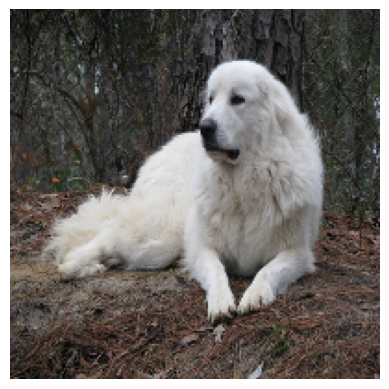

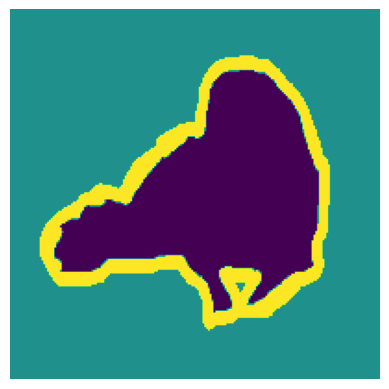

In [85]:
im, target = next(iter(train_dl))
plt.axis("off")
plt.imshow(im[0].permute(1, 2, 0))
display_target_tensor(target[0])